In [84]:
# Import required libraries
import pandas as pd  # Primary data manipulation library
import numpy as np   # Numerical operations
from pathlib import Path  # Object-oriented filesystem paths
from datetime import datetime  # Date/time handling
import os                           # For file and folder operations
import matplotlib.pyplot as plt     # For plotting graphs
import seaborn as sns               # For advanced data visualizations
# Create a folder to save transformed files if it doesn't already exist
os.makedirs("transformed", exist_ok=True)


# 1. Transforming raw_data.csv
#### 1.1 Load the Cleaned Raw Data

In [85]:
# Load the cleaned raw dataset from the 'data' directory
raw_df = pd.read_csv("data/raw_data_cleaned.csv")


In [86]:
# Add validation to check successful loading of a DataFrame
def validate_load(df, name):
    # Check if the DataFrame is empty (has no rows or columns)
    if df.empty:
        # Raise an error if no data was loaded
        raise ValueError(f"{name} DataFrame is empty!")
    
    # If the DataFrame is not empty, print a success message with its shape
    print(f"{name} loaded successfully with shape {df.shape}")

# Call the validation function to verify the raw_df was loaded correctly
validate_load(raw_df, "Raw Data")


Raw Data loaded successfully with shape (100, 7)


#### 1.2 Remove Duplicate Rows

In [87]:
# Print the number of duplicate rows before removing
print("Duplicates in raw_df before:", raw_df.duplicated().sum())

# Drop any duplicate rows in the DataFrame
raw_df = raw_df.drop_duplicates()

# Print the number of duplicate rows after removing
print("Duplicates in raw_df after:", raw_df.duplicated().sum())


Duplicates in raw_df before: 1
Duplicates in raw_df after: 0


In [88]:
# Define a function to visualize missing values using a bar plot
def plot_missing_values(df, title):
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=missing.values, y=missing.index, palette="viridis")
    plt.title(title)
    plt.xlabel("Missing Values Count")
    plt.ylabel("Columns")
    plt.tight_layout()
    plt.show()
  


#### 1.3 Handle Missing Values

In [89]:
# Display how many missing values each column has before cleaning
print("Missing values in raw_df before:\n", raw_df.isnull().sum())

# 1. Fill missing 'quantity' with the column mean
raw_df["quantity"] = raw_df["quantity"].fillna(raw_df["quantity"].mean())

# 2. Fill missing 'unit_price' using median grouped by 'product'
raw_df["unit_price"] = raw_df.groupby("product")["unit_price"].transform(
    lambda x: x.fillna(x.median())
)

# 3. Fill missing 'customer_name' with 'Unknown'
raw_df["customer_name"] = raw_df["customer_name"].fillna("Unknown")

# 4. Drop rows where 'order_date' is missing
raw_df = raw_df.dropna(subset=["order_date"])

# 5. Fill missing 'region' with 'Not Specified'
raw_df["region"] = raw_df["region"].fillna("Not Specified")

# Show the updated missing values
print("Missing values in raw_df AFTER handling:\n", raw_df.isnull().sum())


Missing values in raw_df before:
 order_id          0
customer_name     1
product           0
quantity         26
unit_price       35
order_date        1
region           25
dtype: int64
Missing values in raw_df AFTER handling:
 order_id         0
customer_name    0
product          0
quantity         0
unit_price       0
order_date       0
region           0
dtype: int64


# Full Dataset (raw_df) – Handling Missing Data
##### 1. quantity: Filled with the mean value
Why:
quantity is a numeric column representing the amount of items ordered. Using the mean ensures that we preserve the average buying behavior without distorting the dataset. It helps maintain data continuity for calculations like total sales.

##### 2. unit_price : Filled using the median within each product group
Why:
Prices vary by product. Using the median within each product category helps avoid the influence of outliers and reflects a more accurate and realistic typical price for each product. This preserves pricing accuracy.

##### 3. customer_name: Filled with "Unknown"
Why:
Since the name identifies the customer but doesn’t affect numeric analysis, using "Unknown" keeps the record usable while signaling that identity is missing. It also prevents unnecessary row deletion, especially when the rest of the data is valid.

##### 4. order_date : Dropped (only 1 record was missing)
Why:
Dates are essential for time-based insights (like trends, daily sales, etc.). With only one missing value, dropping the row avoids misleading time-based analysis while having minimal impact on overall data quantity.

##### 5. region : Filled with "Not Specified"
Why:
Since region is a categorical variable, inserting "Not Specified" clearly indicates missing information without falsely assigning a known location. This allows regional grouping and analysis without losing any records.

#### 1.4 Add total_price Column

In [90]:
# Create a new column called 'total_price' by multiplying quantity and unit_price
raw_df["total_price"] = raw_df["quantity"] * raw_df["unit_price"]

# Show a preview of the new 'total_price' column alongside input columns
print(raw_df[["quantity", "unit_price", "total_price"]].head())


   quantity  unit_price  total_price
0  1.958904       500.0   979.452055
1  1.958904       250.0   489.726027
2  2.000000       250.0   500.000000
3  2.000000       750.0  1500.000000
4  3.000000       500.0  1500.000000


#### 1.5 Convert Order Date to Date Format

In [91]:
# Convert 'order_date' column from string to datetime format
raw_df["order_date"] = pd.to_datetime(raw_df["order_date"], errors="coerce")

# Print the data type to confirm successful conversion
print("Converted order_date type (raw_df):", raw_df["order_date"].dtype)


Converted order_date type (raw_df): datetime64[ns]


#### 1.6 Drop Unnecessary Columns

In [92]:
# Print columns before dropping 'Unnamed' ones
print("raw_df columns BEFORE cleanup:\n", raw_df.columns)

# Remove any columns that have names like 'Unnamed', which are often auto-generated
raw_df = raw_df.loc[:, ~raw_df.columns.str.contains("^Unnamed")]

# Print final list of columns to confirm cleanup
print("raw_df columns after cleanup:\n", raw_df.columns)


raw_df columns BEFORE cleanup:
 Index(['order_id', 'customer_name', 'product', 'quantity', 'unit_price',
       'order_date', 'region', 'total_price'],
      dtype='object')
raw_df columns after cleanup:
 Index(['order_id', 'customer_name', 'product', 'quantity', 'unit_price',
       'order_date', 'region', 'total_price'],
      dtype='object')


In [93]:

# Make sure 'total_price' has no missing values before processing
raw_df['total_price'] = raw_df['total_price'].fillna(0)

# Try to segment customers into 3 tiers based on how much they spend
try:
    # Split total_price into 3 quantile-based bins: Bronze, Silver, Gold
    raw_df['customer_tier'] = pd.qcut(
        raw_df['total_price'],
        q=3,
        labels=['Bronze', 'Silver', 'Gold'],
        duplicates='drop'  # Handle identical edges safely
    )
except ValueError:
    # If qcut fails (e.g. too many duplicate values), add small noise to break ties
    raw_df['total_price'] += np.random.uniform(-0.001, 0.001, len(raw_df))

    # Retry customer segmentation
    raw_df['customer_tier'] = pd.qcut(
        raw_df['total_price'],
        q=3,
        labels=['Bronze', 'Silver', 'Gold']
    )

# Extract the weekday name from the order_date (e.g., 'Monday', 'Tuesday', etc.)
raw_df['purchase_day'] = pd.to_datetime(raw_df['order_date']).dt.day_name()
# Display the first few rows of relevant new columns
print(raw_df[['customer_name', 'total_price', 'customer_tier', 'order_date', 'purchase_day']].head())



  customer_name  total_price customer_tier order_date purchase_day
0         Diana   979.452055        Silver 2024-01-20     Saturday
1           Eve   489.726027        Bronze 2024-04-29       Monday
2       Charlie   500.000000        Bronze 2024-01-08       Monday
3           Eve  1500.000000          Gold 2024-01-07       Sunday
4           Eve  1500.000000          Gold 2024-03-07     Thursday


In [94]:
# VALIDATION FUNCTION 
def validate_transforms(df, name):
    """Enhanced validation checks with proper error handling"""
    
    # Print the start of validation for the specific DataFrame
    print(f"\n=== VALIDATING {name} ===")
    
    try:
        # 1. Check for duplicate rows
        # Duplicates can skew analysis, so we raise an error if any are found
        if df.duplicated().any():
            raise ValueError("Duplicate rows exist")
        
        # 2. Check for missing values in key columns
        # Ensure essential columns are complete (no NaN)
        for col in ['customer_id', 'total_price', 'order_date']:
            if col in df.columns and df[col].isnull().any():
                raise ValueError(f"Null values found in {col}")
        
        # 3. Check for expected customer tiers if the column exists
        # This confirms the segmentation logic has been applied correctly
        if 'customer_tier' in df.columns:
            # Drop any nulls before comparing to expected tiers
            existing_tiers = set(df['customer_tier'].dropna().unique())
            expected_tiers = {'Bronze', 'Silver', 'Gold'}
            if existing_tiers != expected_tiers:
                raise ValueError(
                    f"Customer tiers mismatch. Found {existing_tiers}, expected {expected_tiers}"
                )
        
        # If all checks pass, confirm validation success
        print(f" {name} passed all validation checks")
        return True
    
    except Exception as e:
        # If any validation check fails, print a descriptive error message
        print(f" Validation failed for {name}: {str(e)}")


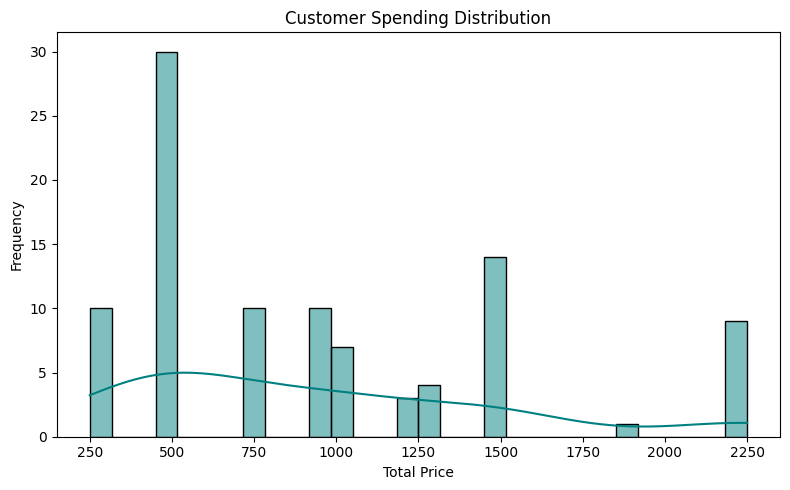

In [95]:
# Ensure 'total_price' exists
raw_df["total_price"] = raw_df["quantity"] * raw_df["unit_price"]

# Plot spending distribution
plt.figure(figsize=(8, 5))
sns.histplot(raw_df["total_price"], bins=30, kde=True, color="teal")
plt.title("Customer Spending Distribution")
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


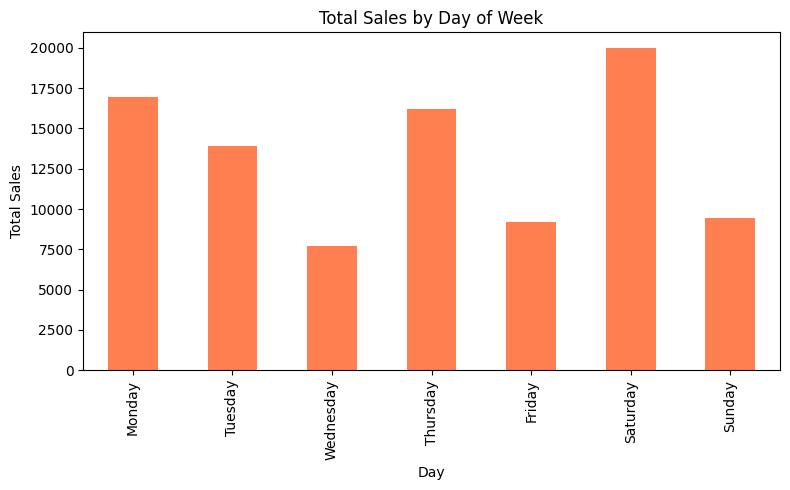

In [96]:
# Total sales grouped by day of week
sales_by_day = raw_df.groupby("purchase_day")["total_price"].sum().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

# Plot the results
sales_by_day.plot(kind="bar", color="coral", figsize=(8, 5))
plt.title("Total Sales by Day of Week")
plt.xlabel("Day")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()


#### 1.7 Save the Transformed Dataset

In [97]:
# Save the cleaned and transformed DataFrame as a new CSV file
raw_df.to_csv("transformed/transformed_full.csv", index=False)

# Confirm the file has been saved successfully
print("raw_df saved as transformed_full.csv")


raw_df saved as transformed_full.csv


# 2. Transforming incremental_data.csv
#### 2.1 Load the Cleaned Incremental Data

In [98]:
# Load the cleaned incremental dataset from the 'data' directory
incr_df = pd.read_csv("data/incremental_data_cleaned.csv")


In [99]:

validate_load(raw_df, "Incremental Data")

Incremental Data loaded successfully with shape (98, 10)


In [100]:
# Add validation
def validate_load(df, name):
    # Check if the DataFrame is empty
    if df.empty:
        # Raise an error if no data is present
        raise ValueError(f"{name} DataFrame is empty!")
    
    # If data exists, print a success message with its shape (rows, columns)
    print(f"{name} loaded successfully with shape {df.shape}")

# Run the validation function for the incremental dataset
validate_load(incr_df, "Incremental Data")


Incremental Data loaded successfully with shape (10, 7)


#### 2.2 Remove Duplicate Rows

In [101]:
# Print the number of duplicate rows before removing
print("Duplicates in incr_df before:", incr_df.duplicated().sum())

# Remove duplicate rows if any exist
incr_df = incr_df.drop_duplicates()

# Print the number of duplicates remaining (should be 0)
print("Duplicates in incr_df after:", incr_df.duplicated().sum())


Duplicates in incr_df before: 0
Duplicates in incr_df after: 0


#### 2.3 Handle Missing Values

In [102]:
# Display how many missing values each column has before cleaning
print("Missing values in incr_df BEFORE handling:\n", incr_df.isnull().sum())

# Fill missing 'quantity' values with the mean
quantity_mean = incr_df["quantity"].mean()
incr_df["quantity"] = incr_df["quantity"].fillna(quantity_mean)

# Fill missing 'customer_name' values with 'Unknown'
incr_df["customer_name"] = incr_df["customer_name"].fillna("Unknown")

# Fill missing 'region' values with 'Not Specified'
incr_df["region"] = incr_df["region"].fillna("Not Specified")

# Display how many missing values each column has after cleaning
print("Missing values in incr_df AFTER handling:\n", incr_df.isnull().sum())


Missing values in incr_df BEFORE handling:
 order_id         0
customer_name    6
product          0
quantity         4
unit_price       0
order_date       0
region           2
dtype: int64
Missing values in incr_df AFTER handling:
 order_id         0
customer_name    0
product          0
quantity         0
unit_price       0
order_date       0
region           0
dtype: int64


 # Incremental Dataset (incr_df) – Handling Missing Data
#### 1. quantity : Filled with the mean value
Why:
For the same reasons as in the full dataset — to preserve average purchase patterns and allow accurate calculation of sales values.

#### 2. customer_name : Filled with "Unknown"
Why:
Helps retain transactions where identity is missing but other data (like what and how much was bought) remains relevant and usable.

#### 3. region : Filled with "Not Specified"
Why:
Retains geographic fields without making incorrect assumptions. Helps prevent skewing regional summaries or analytics.

 No missing values in unit_price, product, or order_date in the incremental dataset, so no action was needed for those.

#### 2.4 Add total_price Column

In [103]:
# Add a 'total_price' column for later analysis
incr_df["total_price"] = incr_df["quantity"] * incr_df["unit_price"]

# Preview the new column
print(incr_df[["quantity", "unit_price", "total_price"]].head())


   quantity  unit_price  total_price
0       1.5       900.0       1350.0
1       1.0       300.0        300.0
2       1.0       600.0        600.0
3       1.5       300.0        450.0
4       2.0       600.0       1200.0


#### 2.5 Convert Order Date to Date Format

In [104]:
# Convert 'order_date' to proper datetime format
incr_df["order_date"] = pd.to_datetime(incr_df["order_date"], errors="coerce")

# Check the data type after conversion
print("Converted order_date type (incr_df):", incr_df["order_date"].dtype)


Converted order_date type (incr_df): datetime64[ns]


#### 2.6 Drop Unnecessary Columns

In [105]:
# Print columns before dropping 'Unnamed' ones
print("raw_df columns BEFORE cleanup:\n", raw_df.columns)

# Remove extra unnamed columns often created during CSV saves
incr_df = incr_df.loc[:, ~incr_df.columns.str.contains("^Unnamed")]

# Confirm final column structure
print("incr_df columns after cleanup:\n", incr_df.columns)


raw_df columns BEFORE cleanup:
 Index(['order_id', 'customer_name', 'product', 'quantity', 'unit_price',
       'order_date', 'region', 'total_price', 'customer_tier', 'purchase_day'],
      dtype='object')
incr_df columns after cleanup:
 Index(['order_id', 'customer_name', 'product', 'quantity', 'unit_price',
       'order_date', 'region', 'total_price'],
      dtype='object')


In [106]:
# Create a new column 'purchase_period' based on the hour of the order
# It categorizes the time into Morning (<12), Afternoon (12–16), and Evening (17+)
incr_df['purchase_period'] = incr_df['order_date'].dt.hour.apply(
    lambda x: 'Morning' if x < 12 else 'Afternoon' if x < 17 else 'Evening'
)

# Create a boolean column 'is_weekend' to indicate if the purchase was made on a weekend (Saturday=5, Sunday=6)
incr_df['is_weekend'] = incr_df['order_date'].dt.weekday >= 5


In [107]:
def validate_transforms(df, name):
    """Enhanced validation checks to ensure data integrity after transformation"""
    
    # Print a header to indicate the start of validation for the given dataset
    print(f"\n=== VALIDATING {name.upper()} ===")
    
    # Check if there are any duplicate rows in the dataset
    # This ensures we didn't accidentally introduce or leave duplicates
    assert not df.duplicated().any(), "Duplicate rows exist"

    # Check for null values in important (key) columns: 'customer_id', 'total_price', and 'order_date'
    # These fields are essential for analysis and reporting; nulls would cause errors or misleading results
    for col in ['customer_id', 'total_price', 'order_date']:
        if col in df.columns:
            assert not df[col].isnull().any(), f"Nulls found in {col}"

    # If the 'customer_tier' column exists, check that it only contains the expected category labels
    # Ensures the segmentation logic worked as intended
    if 'customer_tier' in df.columns:
        assert set(df['customer_tier'].unique()) == {'Bronze', 'Silver', 'Gold'}, "Tiers incorrect"

    # Final confirmation that all validation checks passed
    print(f" {name} passed all validation checks")


#### 2.7 Save the Transformed Dataset

In [108]:
# Save the cleaned and transformed incremental dataset
incr_df.to_csv("transformed/transformed_incremental.csv", index=False)

# Confirm the file was saved
print("incr_df saved as transformed_incremental.csv")


incr_df saved as transformed_incremental.csv
